# Keras MNIST classifier with random-search hyper-parameter optimization

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# Data libraries
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras import backend as K
import tensorflow as tf

# Local imports
from mnist import load_data, build_model

%matplotlib notebook

Using TensorFlow backend.


In [2]:
# Concurrency configuration
n_inter_threads = 2
n_intra_threads = 6
config = tf.ConfigProto(
    inter_op_parallelism_threads=n_inter_threads,
    intra_op_parallelism_threads=n_intra_threads,
)
session = tf.Session(config=config)
K.set_session(session)

## Load the data

In [3]:
x_train, y_train, x_test, y_test = load_data()

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


## Define the HPO strategy

In [4]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 16
grid_h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
grid_dropout = np.random.rand(n_hpo_trials)
grid_optimizer = np.random.choice(
    [keras.optimizers.Adadelta, keras.optimizers.Adam, keras.optimizers.Nadam],
    size=n_hpo_trials)

# Training config
batch_size = 128
n_epochs = 16
valid_frac = 0.17

## Run the trainings

In [7]:
def build_and_train(x_train, y_train, valid_frac, batch_size, n_epochs,
                    h1, h2, h3, dropout, optimizer, verbose=0):
    # Build the model
    model = build_model(h1=h1, h2=h2, h3=h3,
                        dropout=dropout,
                        optimizer_type=optimizer)
    # Train the model
    history = model.fit(x_train, y_train,
                        validation_split=valid_frac,
                        batch_size=batch_size, epochs=n_epochs,
                        verbose=verbose)
    return model, history

In [8]:
all_models = []
all_histories = []

# Loop over hps
for ihp in range(n_hpo_trials):
    print('Hyper-parameter trial', ihp)
    print('  Hidden %i, %i, %i' % (grid_h1[ihp], grid_h2[ihp], grid_h3[ihp]))
    print('  Dropout %.4f' % grid_dropout[ihp])
    print('  Optimizer', grid_optimizer[ihp].__name__)
    
    model, history = build_and_train(x_train, y_train, valid_frac=valid_frac,
                                     batch_size=batch_size, n_epochs=n_epochs,
                                     h1=grid_h1[ihp], h2=grid_h2[ihp], h3=grid_h3[ihp],
                                     dropout=grid_dropout[ihp],
                                     optimizer=grid_optimizer[ihp])
    
    # Use final validation accuracy as objective metric
    score = history.history['val_acc'][-1]
    print('  Final score', score)
    
    # Save the model and history
    all_models.append(model)
    all_histories.append(history)

Hyper-parameter trial 0
  Hidden 64, 8, 16
  Dropout 0.3865
  Optimizer Adadelta
  Final score 0.979607843231
Hyper-parameter trial 1
  Hidden 4, 4, 16
  Dropout 0.9026
  Optimizer Adadelta
  Final score 0.685588235481
Hyper-parameter trial 2
  Hidden 32, 8, 16
  Dropout 0.4499
  Optimizer Adadelta
  Final score 0.973137254995
Hyper-parameter trial 3
  Hidden 32, 64, 8
  Dropout 0.6131
  Optimizer Adadelta
  Final score 0.965294117834
Hyper-parameter trial 4
  Hidden 32, 32, 32
  Dropout 0.9023
  Optimizer Adadelta
  Final score 0.931960784173
Hyper-parameter trial 5
  Hidden 8, 4, 128
  Dropout 0.0993
  Optimizer Nadam
  Final score 0.98803921578
Hyper-parameter trial 6
  Hidden 32, 32, 64
  Dropout 0.9698
  Optimizer Adadelta
  Final score 0.106568627445
Hyper-parameter trial 7
  Hidden 16, 4, 64
  Dropout 0.6531
  Optimizer Nadam
  Final score 0.979901960878
Hyper-parameter trial 8
  Hidden 64, 16, 32
  Dropout 0.1709
  Optimizer Adam
  Final score 0.987549019701
Hyper-parameter tri

## Model selection and evaluation

In [9]:
all_last_scores = np.array([h.history['val_acc'][-1] for h in all_histories])
all_best_scores = np.array([max(h.history['val_acc']) for h in all_histories])

### Best model

Hyperparameters: trial 9 hidden 4-32-128 dropout 0.358 opt Adam
  Last validation accuracy 0.9907
  Best validation accuracy 0.9907


<IPython.core.display.Javascript object>


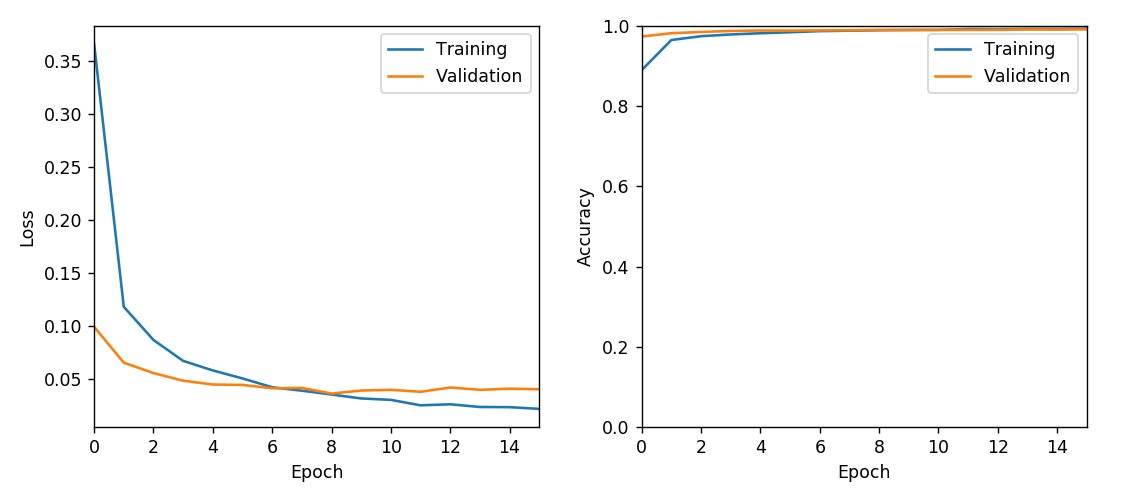

In [10]:
# Find the best in terms of final validation set accuracy
i = all_last_scores.argmax()
h = all_histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i].__name__))
print('  Last validation accuracy %.4f' % all_last_scores[i])
print('  Best validation accuracy %.4f' % all_best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h.epoch, h.history['loss'], label='Training')
plt.plot(h.epoch, h.history['val_loss'], label='Validation')
plt.xlim((min(h.epoch), max(h.epoch)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h.history['acc'], label='Training')
plt.plot(h.history['val_acc'], label='Validation')
plt.xlim((min(h.epoch), max(h.epoch)))
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Worst model

Hyperparameters: trial 6 hidden 32-32-64 dropout 0.970 opt Adadelta
  Last validation accuracy 0.1066
  Best validation accuracy 0.1066


<IPython.core.display.Javascript object>


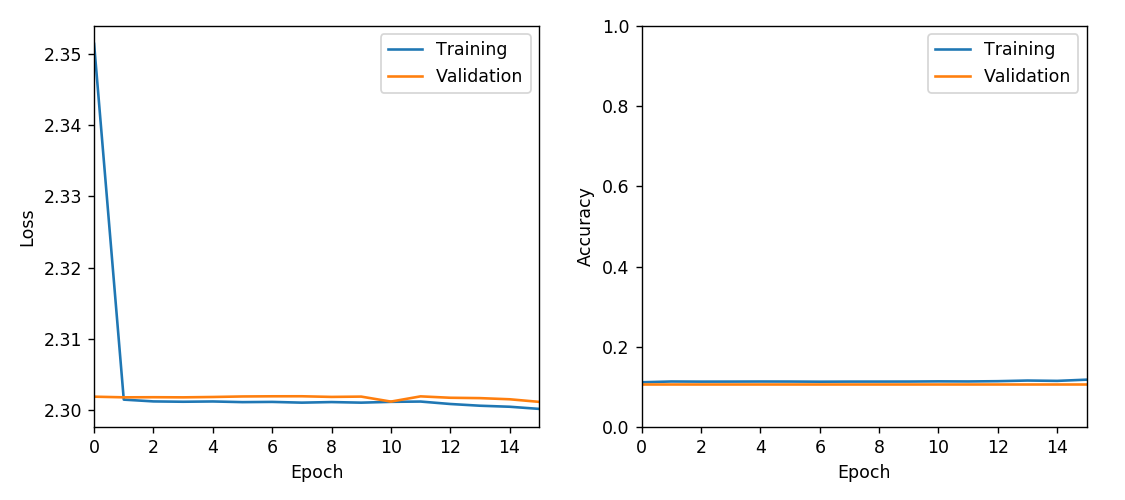

In [11]:
# Find the worst in terms of final validation set accuracy
i = all_last_scores.argmin()
h = all_histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i].__name__))
print('  Last validation accuracy %.4f' % all_last_scores[i])
print('  Best validation accuracy %.4f' % all_best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h.epoch, h.history['loss'], label='Training')
plt.plot(h.epoch, h.history['val_loss'], label='Validation')
plt.xlim((min(h.epoch), max(h.epoch)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h.history['acc'], label='Training')
plt.plot(h.history['val_acc'], label='Validation')
plt.xlim((min(h.epoch), max(h.epoch)))
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Test set evaluation

In [12]:
best_model = all_models[all_last_scores.argmax()]
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0303653424745
Test accuracy: 0.9911
